<a href="https://colab.research.google.com/github/Lucs1590/strava-analysis/blob/main/strava_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strava Analysis
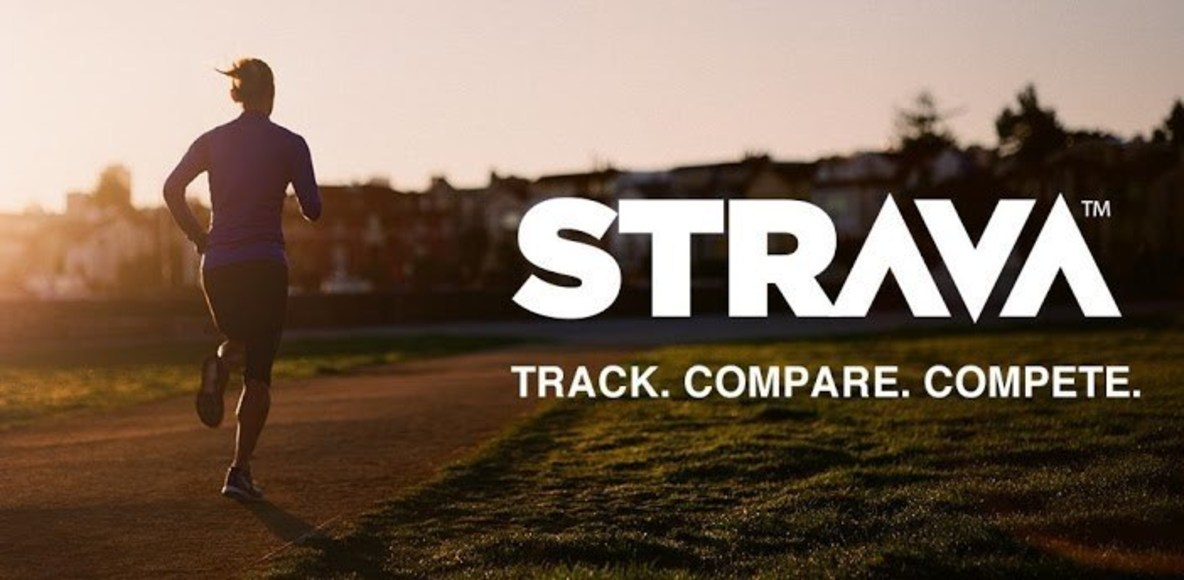
This notebook aims to make a data exploration searching by a pattern on user data and, after, try to predict the pace based on a distance and elevation.


## Imports

In [1]:
# general

# df and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# machine learning and math
import math
from sklearn.feature_selection import mutual_info_classif

## Getting data and first contact

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
%run -i 'get_activities.py'

In [4]:
df = pd.read_csv('result/strava_all_activities.csv')

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0.1,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,workout_type,id,external_id,upload_id,start_date,start_date_local,timezone,utc_offset,start_latlng,end_latlng,location_city,location_state,location_country,start_latitude,start_longitude,achievement_count,kudos_count,comment_count,athlete_count,photo_count,trainer,commute,manual,private,visibility,flagged,gear_id,from_accepted_tag,upload_id_str,average_speed,max_speed,average_cadence,has_heartrate,average_heartrate,max_heartrate,heartrate_opt_out,display_hide_heartrate_option,elev_high,elev_low,pr_count,total_photo_count,has_kudoed,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_watts,kilojoules,device_watts
0,0,0,2,Corrida na hora do almoço,13578.7,4290,4338,153.8,Run,NaN,6161919342,shealthc4754812-fbd7-4399-8690-dc67f94831fd.tcx,6.548207e+09,2021-10-24T14:25:27Z,2021-10-24T11:25:27Z,(GMT-03:00) America/Sao_Paulo,-10800.0,"[-22.07072, -50.293137]","[-22.018898, -50.3827]",NaN,NaN,Brasil,-22.070720,-50.382700,2,8,2,1,0,False,False,False,False,everyone,False,g7550415,False,6.548207e+09,3.165,4.454,80.7,True,178.6,187.0,False,True,603.1,495.5,0,0,False,47005114,1,a6161919342,p`veCnw}qHT?r@^\Fn@Ph@Xn@R^`@DRaAbD[rBkA~Fg@hD...,2,NaN,NaN,NaN
1,1,1,2,Corrida ao entardecer,9159.4,2910,2910,105.9,Run,NaN,6149848501,shealth1119d045-04d2-4282-8fda-3598e1022cb5.tcx,6.535352e+09,2021-10-21T22:08:10Z,2021-10-21T19:08:10Z,(GMT-03:00) America/Sao_Paulo,-10800.0,"[-22.070625, -50.29312]","[-22.073082, -50.295395]",NaN,NaN,Brasil,-22.070625,-50.295395,0,4,0,1,0,False,False,False,False,everyone,False,g7550415,False,6.535352e+09,3.148,4.442,82.5,True,175.0,185.0,False,True,605.9,589.0,0,0,False,47005114,1,a6149848501,h`veChw}qHFAR@z@b@~C`AJD@HEj@y@dDObAcArEORO@KC...,2,NaN,NaN,NaN
2,2,2,2,Evening Activity,0.0,1036,1036,0.0,Workout,NaN,6143132728,2f8ca141-8ac5-4889-90fa-6197b351e378-activity.fit,6.528219e+09,2021-10-20T22:05:55Z,2021-10-20T19:05:55Z,(GMT-03:00) America/Sao_Paulo,-10800.0,[],[],NaN,NaN,Brasil,NaN,NaN,0,2,0,1,0,True,False,False,False,everyone,False,NaN,False,6.528219e+09,0.000,0.000,NaN,True,134.3,165.0,False,True,NaN,NaN,0,0,False,47005114,1,a6143132728,NaN,2,NaN,NaN,NaN
3,3,3,2,Corrida ao entardecer,5060.2,1351,1355,182.5,Run,NaN,6133840173,shealthe3ba4ef7-b6a6-4313-b189-ae83e1ed3f6b.tcx,6.518410e+09,2021-10-18T21:57:08Z,2021-10-18T18:57:08Z,(GMT-03:00) America/Sao_Paulo,-10800.0,"[-22.072893, -50.30649]","[-22.073616, -50.307014]",NaN,NaN,Brasil,-22.072893,-50.307014,3,5,0,3,0,False,False,False,False,everyone,False,g7550415,False,6.518410e+09,3.746,5.400,82.3,True,173.2,186.0,False,True,606.7,594.9,1,0,False,47005114,1,a6133840173,rbveCpn`rHp@tAzAxDHJLA`@[BMAOeCaGMOK?M@e@XCD@L...,2,NaN,NaN,NaN
4,4,4,2,Corrida vespertina,3366.0,1006,1006,46.4,Run,NaN,6133207604,shealthd84704a1-857b-4b61-a340-2d15249a5f12.tcx,6.517749e+09,2021-10-06T20:22:51Z,2021-10-06T17:22:51Z,(GMT-03:00) America/Sao_Paulo,-10800.0,"[-22.07051, -50.293083]","[-22.073322, -50.306496]",NaN,NaN,Brasil,-22.070510,-50.306496,0,3,0,2,0,False,False,False,False,everyone,False,g7550415,False,6.517749e+09,3.346,4.400,80.9,True,167.4,178.0,False,True,605.9,589.0,0,0,False,47005114,1,a6133207604,l`veCrw}qHJCJ?r@Zt@NTLxAh@FJALYv@aAzEq@vCQz@GH...,2,NaN,NaN,NaN


In [6]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'resource_state', 'name', 'distance',
       'moving_time', 'elapsed_time', 'total_elevation_gain', 'type',
       'workout_type', 'id', 'external_id', 'upload_id', 'start_date',
       'start_date_local', 'timezone', 'utc_offset', 'start_latlng',
       'end_latlng', 'location_city', 'location_state', 'location_country',
       'start_latitude', 'start_longitude', 'achievement_count', 'kudos_count',
       'comment_count', 'athlete_count', 'photo_count', 'trainer', 'commute',
       'manual', 'private', 'visibility', 'flagged', 'gear_id',
       'from_accepted_tag', 'upload_id_str', 'average_speed', 'max_speed',
       'average_cadence', 'has_heartrate', 'average_heartrate',
       'max_heartrate', 'heartrate_opt_out', 'display_hide_heartrate_option',
       'elev_high', 'elev_low', 'pr_count', 'total_photo_count', 'has_kudoed',
       'athlete.id', 'athlete.resource_state', 'map.id',
       'map.summary_polyline', 'map.resource_state', 'average_wa

In [7]:
df.shape

(205, 59)

In [8]:
df.isnull().sum().sum()

1978

In [9]:
null_df = [[col, df[col].isnull().sum()] for col in df.columns]
list(filter(lambda x: x[1]>0, null_df))

[['workout_type', 81],
 ['external_id', 89],
 ['upload_id', 40],
 ['location_city', 205],
 ['location_state', 205],
 ['location_country', 3],
 ['start_latitude', 44],
 ['start_longitude', 44],
 ['gear_id', 87],
 ['from_accepted_tag', 40],
 ['upload_id_str', 40],
 ['average_cadence', 92],
 ['average_heartrate', 159],
 ['max_heartrate', 159],
 ['elev_high', 44],
 ['elev_low', 44],
 ['map.summary_polyline', 46],
 ['average_watts', 186],
 ['kilojoules', 186],
 ['device_watts', 184]]

## Data manipulation

In [10]:
raw_df = df

In [11]:
selected_columns = ['id','name', 'distance', 'moving_time', 'total_elevation_gain', 'type',
                    'start_date_local',  'start_latitude', 'start_longitude', 'athlete_count','average_speed',
                    'max_speed','average_cadence', 'average_heartrate','elev_high', 'elev_low', 'pr_count',
                    'average_watts', 'kilojoules', 'device_watts']

In [12]:
df = df[selected_columns]
df.head()

,id,name,distance,moving_time,total_elevation_gain,type,start_date_local,start_latitude,start_longitude,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts
0,6161919342,Corrida na hora do almoço,13578.7,4290,153.8,Run,2021-10-24T11:25:27Z,-22.070720,-50.382700,1,3.165,4.454,80.7,178.6,603.1,495.5,0,NaN,NaN,NaN
1,6149848501,Corrida ao entardecer,9159.4,2910,105.9,Run,2021-10-21T19:08:10Z,-22.070625,-50.295395,1,3.148,4.442,82.5,175.0,605.9,589.0,0,NaN,NaN,NaN
2,6143132728,Evening Activity,0.0,1036,0.0,Workout,2021-10-20T19:05:55Z,NaN,NaN,1,0.000,0.000,NaN,134.3,NaN,NaN,0,NaN,NaN,NaN
3,6133840173,Corrida ao entardecer,5060.2,1351,182.5,Run,2021-10-18T18:57:08Z,-22.072893,-50.307014,3,3.746,5.400,82.3,173.2,606.7,594.9,1,NaN,NaN,NaN
4,6133207604,Corrida vespertina,3366.0,1006,46.4,Run,2021-10-06T17:22:51Z,-22.070510,-50.306496,2,3.346,4.400,80.9,167.4,605.9,589.0,0,NaN,NaN,NaN


In [13]:
df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_63848/4095640816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')


In [14]:
df = df.sort_values(by='start_date_local')

In [15]:
df['start_time'] = df['start_date_local'].dt.time
df['start_date'] = df['start_date_local'].dt.date

In [16]:
df = df.drop('start_date_local', 1)
df.head()

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_63848/2372681409.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('start_date_local', 1)


,id,name,distance,moving_time,total_elevation_gain,type,start_latitude,start_longitude,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts,start_time,start_date
204,2753119647,Evening Ride,1585.6,345,10.3,Ride,-22.070302,-50.306393,1,4.596,8.9,NaN,NaN,606.2,596.4,0,NaN,NaN,False,20:09:18,2019-09-30
203,2753195842,Evening Run,1556.1,477,26.0,Run,-22.067056,-50.306762,1,3.262,3.6,NaN,NaN,602.6,589.4,0,NaN,NaN,NaN,20:33:06,2019-09-30
202,2753233770,Night Ride,225.4,61,0.0,Ride,-22.069931,-50.304896,1,3.695,7.1,NaN,NaN,607.3,599.1,0,NaN,NaN,False,21:15:01,2019-09-30
201,2755746533,Evening Ride,203.7,62,0.0,Ride,-22.070402,-50.294613,1,3.285,7.7,NaN,NaN,599.0,596.8,0,28.3,1.8,False,20:08:30,2019-10-01
200,2755823383,Evening Run,421.4,4,0.0,Run,-22.067112,-50.308304,1,105.350,1.8,NaN,NaN,597.5,593.5,0,NaN,NaN,NaN,20:25:05,2019-10-01


In [17]:
df = df.drop(df[df.average_speed > 30].index)

## Visualization

Text(0.5, 1.0, 'Exercices')

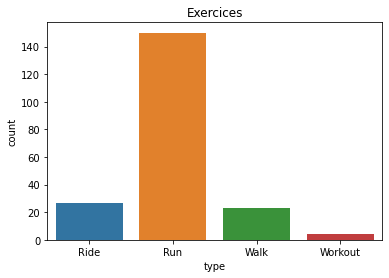

In [18]:
fig = sns.countplot(x='type', data=df).set_title('Exercices')
fig

In [19]:
df['year']= df['start_date'].map(lambda x: x.year)

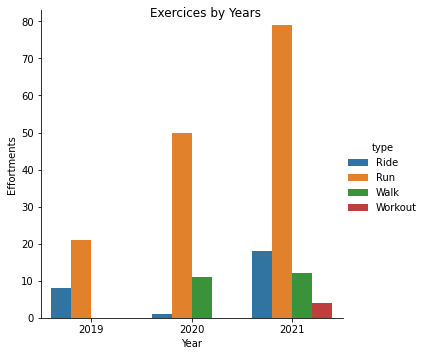

In [20]:
fig = sns.catplot(x='year', hue='type', data=df, kind='count')
fig.fig.suptitle('Exercices by Years')
fig.set_xlabels('Year')
fig.set_ylabels('Effortments')
fig

## Running Analysis

In [21]:
runs = df.loc[df['type'] == 'Run']
runs

,id,name,distance,moving_time,total_elevation_gain,type,start_latitude,start_longitude,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts,start_time,start_date,year
203,2753195842,Evening Run,1556.1,477,26.0,Run,-22.067056,-50.306762,1,3.262,3.600,NaN,NaN,602.6,589.4,0,NaN,NaN,NaN,20:33:06,2019-09-30,2019
197,2781031587,Night Run,102.0,61,0.0,Run,-22.068252,-50.308969,1,1.672,1.900,NaN,NaN,594.4,589.9,0,NaN,NaN,NaN,21:40:58,2019-10-09,2019
195,2781127867,Evening Ride,2586.9,2756,54.0,Run,-22.067178,-50.308717,1,0.939,3.800,NaN,NaN,597.5,588.2,0,NaN,NaN,NaN,19:06:54,2019-10-11,2019
193,2789528029,Evening Run,2219.2,1068,39.3,Run,-22.067135,-50.309288,2,2.078,3.700,NaN,NaN,597.5,588.8,3,NaN,NaN,NaN,19:50:11,2019-10-14,2019
192,2828174770,Morning Run,4505.2,2092,41.4,Run,-22.108612,-50.195598,2,2.154,3.700,NaN,NaN,618.5,595.9,4,NaN,NaN,NaN,07:15:57,2019-10-30,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,6064980291,Corrida ao entardecer,5071.1,1559,233.4,Run,-22.073723,-50.308000,3,3.253,6.500,81.7,167.8,604.9,587.9,0,NaN,NaN,NaN,18:37:37,2021-10-04,2021
4,6133207604,Corrida vespertina,3366.0,1006,46.4,Run,-22.070510,-50.306496,2,3.346,4.400,80.9,167.4,605.9,589.0,0,NaN,NaN,NaN,17:22:51,2021-10-06,2021
3,6133840173,Corrida ao entardecer,5060.2,1351,182.5,Run,-22.072893,-50.307014,3,3.746,5.400,82.3,173.2,606.7,594.9,1,NaN,NaN,NaN,18:57:08,2021-10-18,2021
1,6149848501,Corrida ao entardecer,9159.4,2910,105.9,Run,-22.070625,-50.295395,1,3.148,4.442,82.5,175.0,605.9,589.0,0,NaN,NaN,NaN,19:08:10,2021-10-21,2021


Text(0.5, 1.0, 'Average Speed vs Distance')

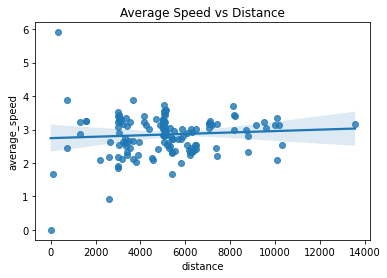

In [22]:
sns.regplot(x='distance', y = 'average_speed', data=runs).set_title("Average Speed vs Distance")

Text(0.5, 1.0, 'Mac Speed vs Distance')

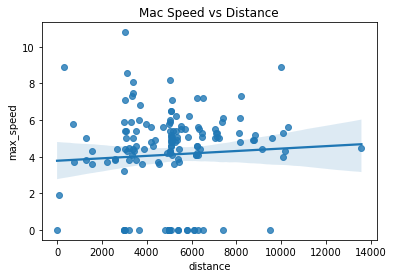

In [23]:
sns.regplot(x='distance', y = 'max_speed', data=runs).set_title("Max Speed vs Distance")

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_63848/3097083979.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


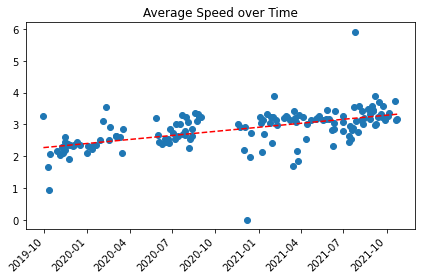

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(runs.start_date)
y = np.asarray(runs.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')

#add trend line
x2 = mdates.date2num(x)

z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

## Biking Analysis

In [25]:
rides = df.loc[df['type'] == 'Ride']
rides

,id,name,distance,moving_time,total_elevation_gain,type,start_latitude,start_longitude,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts,start_time,start_date,year
204,2753119647,Evening Ride,1585.6,345,10.3,Ride,-22.070302,-50.306393,1,4.596,8.9,NaN,NaN,606.2,596.4,0,NaN,NaN,False,20:09:18,2019-09-30,2019
202,2753233770,Night Ride,225.4,61,0.0,Ride,-22.069931,-50.304896,1,3.695,7.1,NaN,NaN,607.3,599.1,0,NaN,NaN,False,21:15:01,2019-09-30,2019
201,2755746533,Evening Ride,203.7,62,0.0,Ride,-22.070402,-50.294613,1,3.285,7.7,NaN,NaN,599.0,596.8,0,28.3,1.8,False,20:08:30,2019-10-01,2019
199,2755853084,Night Ride,192.9,61,0.0,Ride,-22.069822,-50.305242,1,3.162,6.2,NaN,NaN,607.1,599.2,0,69.3,4.2,False,21:02:29,2019-10-01,2019
198,2776607227,Night Ride,1630.9,373,24.8,Ride,-22.070381,-50.306692,1,4.372,9.6,NaN,NaN,611.2,596.8,0,77.7,29.0,False,21:13:16,2019-10-09,2019
196,2781127862,Evening Ride,1608.2,351,25.0,Ride,-22.070452,-50.306611,1,4.582,7.9,NaN,NaN,611.2,596.8,0,87.2,30.6,False,18:47:12,2019-10-11,2019
194,2781140196,Evening Ride,305.9,88,0.0,Ride,-22.069888,-50.304126,1,3.476,6.6,NaN,NaN,607.0,599.1,0,70.0,6.2,False,19:55:40,2019-10-11,2019
189,2858518319,Evening Ride,1980.0,417,32.1,Ride,-22.070432,-50.306708,1,4.748,10.1,NaN,NaN,611.2,587.4,0,89.8,37.4,False,20:37:02,2019-11-11,2019
173,3002630090,Morning Ride,1544.2,310,15.1,Ride,-22.070524,-50.293364,1,4.981,8.5,NaN,NaN,611.1,596.8,0,76.5,23.7,False,10:39:02,2020-01-11,2020
111,4573720222,Evening Ride,11300.0,1863,0.0,Ride,NaN,NaN,1,6.065,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,19:21:18,2021-01-05,2021


Text(0.5, 1.0, 'Average Speed vs Distance')

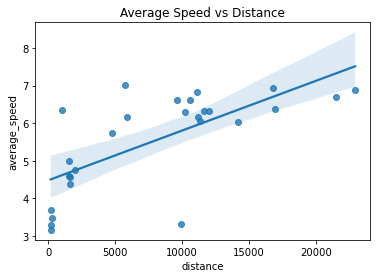

In [26]:
sns.regplot(x='distance', y = 'average_speed', data=rides).set_title("Average Speed vs Distance")

Text(0.5, 1.0, 'Mac Speed vs Distance')

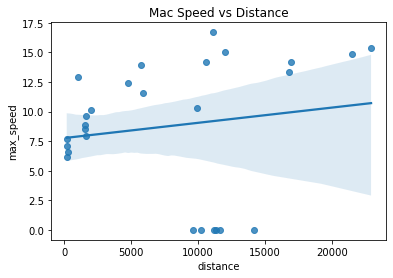

In [27]:
sns.regplot(x='distance', y = 'max_speed', data=rides).set_title("Max Speed vs Distance")

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_63848/2184546799.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


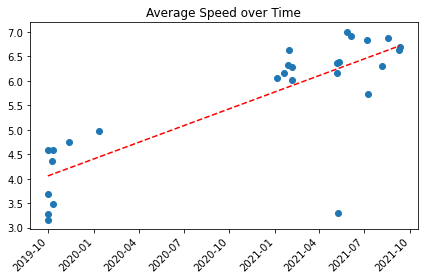

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(rides.start_date)
y = np.asarray(rides.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')

#add trend line
x2 = mdates.date2num(x)

z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

Text(0.5, 1.0, 'Distance vs Elevation Gain')

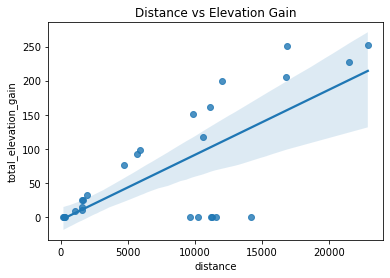

In [33]:
sns.regplot(x='distance', y = 'total_elevation_gain', data = rides ).set_title("Distance vs Elevation Gain")